In [1]:
# Based on SF Education's notebook

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import scipy.stats as sps
import scipy.optimize as spop
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('../data/BAC_2002-01-01_2022-12-31_1d.csv', index_col=0)
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2001-12-31,19.101077,19.101077,18.822426,18.861378,5397400,0.0,0.0
2002-01-02,18.669628,18.906331,18.609703,18.864384,8669200,0.0,0.0
2002-01-03,18.864382,19.146030,18.804457,18.843409,8237600,0.0,0.0
2002-01-04,18.912315,19.220929,18.879356,19.137033,10598600,0.0,0.0
2002-01-07,18.696586,18.990218,18.696586,18.909319,10852200,0.0,0.0


In [3]:
close = df['Close'].to_frame()
close['rank']=(close['Close'].rank(method='first'))/(len(close))
close = close.reset_index(drop=True)

In [4]:
close.head()

,Close,rank
0,18.861378,0.397882
1,18.864384,0.398071
2,18.843409,0.397315
3,19.137033,0.400530
4,18.909319,0.398449


In [9]:
mean = np.average(close['Close'])
med = np.median(close['Close'])
std = np.std(close['Close'])
var = std**2
skew = sps.skew(close['Close'])
kurt = sps.kurtosis(close['Close'])

In [10]:
print(f'Mean:     {mean}')
print(f'Median:   {med}')
print(f'Std:      {std}')
print(f'Variance: {var}')
print(f'Skew:     {skew}')
print(f'Kurtosis: {kurt}')

Mean:     22.205834364295907
Median:   22.27399253845215
Std:      10.209689196412825
Variance: 104.23775348734875
Skew:     0.1827889739628597
Kurtosis: -0.9625491221002185


In [11]:
# оценим параметры распределения Лапласа методом максимального правдоподобия
loc_laplace = med
scale_laplace = np.average(abs(close['Close'] - med))

In [12]:
# оценим параметры распределения Коши методом моментов
loc_cauchy = med
scale_cauchy = (np.percentile(close['Close'], 0.75) - np.percentile(close['Close'], 0.25)) / 2

In [39]:
# оценим параметры распределения Коши методом максимального правдопододия
def cauchy_mle(k:list)->float:
    return -np.sum(np.log(1/(np.pi
                             *k[1]
                             *(1 + ((close['Close'] - k[0]) / k[1])**2)
                            )))

res = spop.minimize(cauchy_mle, [loc_cauchy, scale_cauchy], method='Powell')
loc_cauchy_mle = res.x[0]
scale_cauchy_mle = res.x[1]

In [40]:
loc_cauchy_mle, scale_cauchy_mle

(33.843439536037636, -101.41606852206861)

In [17]:
# оценим параметры гиперболического секанта методом максимального правдопододия
def hypersecant_mle(k:list)->float:
    return -np.sum(np.log(np.pi/(k[1])
                          *np.exp(np.pi/2*(close['Close']-k[0])/k[1])
                          /(1+np.exp(np.pi*(close['Close']-k[0])/k[1]))
                         ))

res = spop.minimize(hypersecant_mle, [mean, std], method='Powell')
loc_hypersecant_mle = res.x[0]
scale_hypersecant_mle = res.x[1]

In [18]:
# оценим параметры логистического распределения методом моментов
loc_logistic = mean
scale_logistic = 3**(1/2)/np.pi*std

In [19]:
# оценим параметры логистического распределения методом максимального правдоподобия
def logistic_mle(k:list)->float:
    return -np.sum(np.log(np.exp(-(close['Close']-k[0])/k[1])
                          /(k[1]*(1+np.exp(-(close['Close']-k[0])/k[1]))**2)
                         ))

res = spop.minimize(logistic_mle, [loc_logistic, scale_logistic], method='Powell')
loc_logistic_mle = res.x[0]
scale_logistic_mle = res.x[1]

In [20]:
# оценим параметры распределения Cmьюдента методом моментов
df_student = 6/kurt + 4
loc_student = mean
scale_student = std*((df_student - 2)/df_student)**(1/2)

In [49]:
# выведем теоретические функции распределения исходя из оцененных параметров
close['Normal'] = sps.norm.cdf(close['Close'], loc=mean, scale=std)

# close['Cauchy-MM'] = 1/np.pi*np.arctan((close['Close']-loc_cauchy)/scale_cauchy)+1/2
close['Cauchy-MM'] = sps.cauchy.cdf(close['Close'], loc=loc_cauchy, scale=scale_cauchy)

close['Cauchy-MMP'] = 1/np.pi*np.arctan((close['Close']-loc_cauchy_mle)/scale_cauchy_mle)+1/2

close['Laplace1'] = 1/2*np.exp((close[close['Close']<=loc_laplace]['Close']-med)/scale_laplace)
close['Laplace2'] = 1-1/2*np.exp(-(close[close['Close']>med]['Close']-loc_laplace)/scale_laplace)
close['Laplace'] = close['Laplace1'].replace(np.nan,0)+close['Laplace2'].replace(np.nan,0)
close['Hyperbolic secant-MM'] = 2/np.pi*np.arctan(np.exp(np.pi*(close['Close']-mean)/(2*std)))
close['Hyperbolic secant-MMP'] = 2/np.pi*np.arctan(np.exp(np.pi*(close['Close']-loc_hypersecant_mle)/(2*scale_hypersecant_mle)))
close['Student'] = sps.t.cdf((close['Close']-loc_student)/(scale_student),df_student,loc=0,scale=1)
close['Logistic-MM'] = 1/(1+np.exp(-(close['Close']-loc_logistic)/scale_logistic))
close['Logistic-MMP'] = 1/(1+np.exp(-(close['Close']-loc_logistic_mle)/scale_logistic_mle))

In [54]:
close.head()

,Close,rank,Normal,Cauchy-MM,Cauchy-MMP,Laplace1,Laplace2,Laplace,Hyperbolic secant-MM,Hyperbolic secant-MMP,Student,Logistic-MM,Logistic-MMP
0,18.861378,0.397882,0.371616,0.028754,0.546686,0.338503,NaN,0.338503,0.342995,0.370656,NaN,0.355681,0.374517
1,18.864384,0.398071,0.371727,0.028780,0.546677,0.338619,NaN,0.338619,0.343125,0.370773,NaN,0.355804,0.374632
2,18.843409,0.397315,0.370951,0.028605,0.546741,0.337808,NaN,0.337808,0.342220,0.369956,NaN,0.354950,0.373832
3,19.137033,0.400530,0.381868,0.031266,0.545839,0.349339,NaN,0.349339,0.355003,0.381464,NaN,0.366982,0.385089
4,18.909319,0.398449,0.373393,0.029162,0.546539,0.340363,NaN,0.340363,0.345066,0.372525,NaN,0.357636,0.376348


In [52]:
(close['Close']-loc_student)/(scale_student)

0      -0.237933
1      -0.237719
2      -0.239211
3      -0.218322
4      -0.234522
          ...   
5283    0.715332
5284    0.719572
5285    0.736537
5286    0.762690
5287    0.761276
Name: Close, Length: 5288, dtype: float64

In [51]:
sps.t.cdf((close['Close']-loc_student)/(scale_student), df_student, loc=0, scale=1)

array([nan, nan, nan, ..., nan, nan, nan])


Normal

супремум равен 0.126
p-значение равно 0.0
распределение не подходит


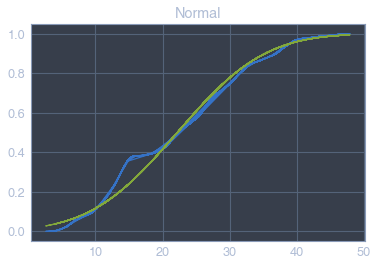


Laplace

супремум равен 0.1493
p-значение равно 0.0
распределение не подходит


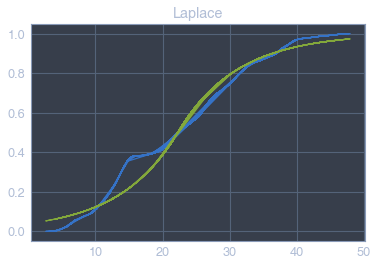


Hyperbolic secant-MM

супремум равен 0.1633
p-значение равно 0.0
распределение не подходит


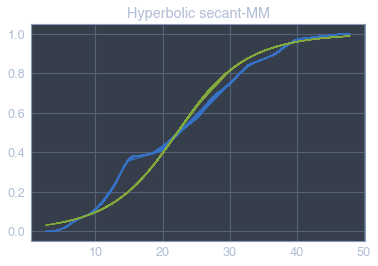


Hyperbolic secant-MMP

супремум равен 0.1275
p-значение равно 0.0
распределение не подходит


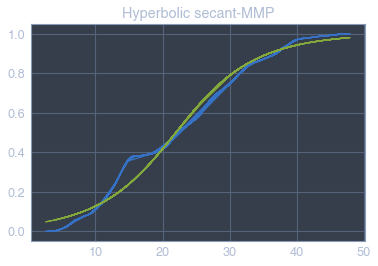


Cauchy-MM

супремум равен 0.4017
p-значение равно 0.0
распределение не подходит


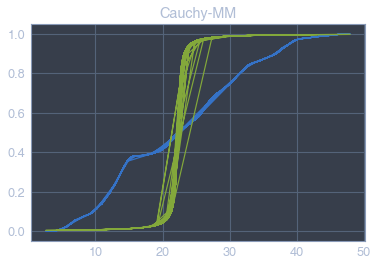


Cauchy-MMP

супремум равен 0.5949
p-значение равно 0.0
распределение не подходит


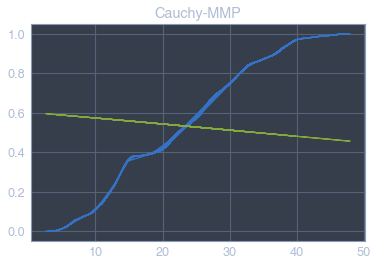


Student

супремум равен nan
p-значение равно nan
распределение не подходит


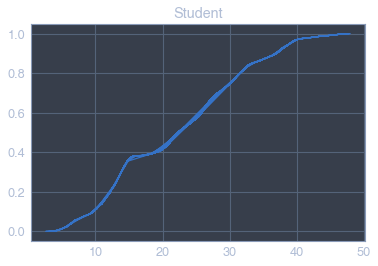


Logistic-MM

супремум равен 0.1487
p-значение равно 0.0
распределение не подходит


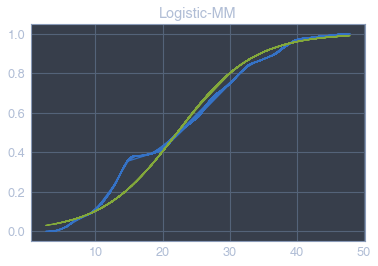


Logistic-MMP

супремум равен 0.1242
p-значение равно 0.0
распределение не подходит


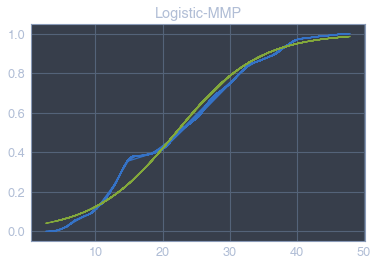

In [27]:
# сравним теоретические функции распределения с эмпирическими для каждого из распределений
distributions = ['Normal',
                 'Laplace',
                 'Hyperbolic secant-MM',
                 'Hyperbolic secant-MMP',
                 'Cauchy-MM',
                 'Cauchy-MMP',
                 'Student',
                 'Logistic-MM',
                 'Logistic-MMP']
for dist in distributions:
    # вычислим супремум (статистику Колмогорова-Смирнова)
    KS_array = abs(close['rank']-close[dist])
    KS = max(KS_array)

    # вычислим p-значения (вероятность, с которой данные подчиняются этому распределению)
    KS_p = np.exp(-KS**2*len(close))

    # визуализируем результат и выведем результаты теста Колмогорова-Смирнова
    print()
    print(dist)
    print()
    print(f'супремум равен {str(round(KS,4))}')
    print(f'p-значение равно {str(round(KS_p,4))}')
    if KS_p > 0.1:
        print('распределение подходит')
    else:
        print('распределение не подходит')
#     plt.figure(dist)
    plt.plot(close['Close'], close['rank'])
    plt.plot(close['Close'], close[dist])
    plt.title(dist)
    plt.show();

In [55]:
def fit_distributions(data):
    pass